In [45]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [46]:
input_shape = (128, 128, 3)

In [47]:
data_dir = 'hackaton_dataset'
CM_ABN = [f for f in os.listdir(data_dir+'/CM_ABN') if f.endswith('.jpg')]
CM_NOR = [f for f in os.listdir(data_dir+'/CM_NOR') if f.endswith('.jpg')]

In [48]:
X = []
Y = []

for img in CM_ABN:
    if "Ab01" in img:
        X.append(img_to_array(load_img(data_dir+'/CM_ABN/'+img)).flatten() / 255.0)
        Y.append(1)
    elif "Ab04" in img:
        X.append(img_to_array(load_img(data_dir+'/CM_ABN/'+img)).flatten() / 255.0)
        Y.append(2)
    elif "Ch02" in img:
        X.append(img_to_array(load_img(data_dir+'/CM_ABN/'+img)).flatten() / 255.0)
        Y.append(3)
    elif "Ch05" in img:
        X.append(img_to_array(load_img(data_dir+'/CM_ABN/'+img)).flatten() / 255.0)
        Y.append(4)
    elif "Mu02" in img:
        X.append(img_to_array(load_img(data_dir+'/CM_ABN/'+img)).flatten() / 255.0)
        Y.append(5)
    elif "Mu04" in img:
        X.append(img_to_array(load_img(data_dir+'/CM_ABN/'+img)).flatten() / 255.0)
        Y.append(6)
for img in CM_NOR:
    X.append(img_to_array(load_img(data_dir+'/CM_NOR/'+img)).flatten() / 255.0)
    Y.append(0)

In [49]:
Y_val_org = Y

#Normalization
X = np.array(X)
Y = tf.keras.utils.to_categorical(Y)

#Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(np.shape(X))
print(np.shape(Y))

(9187, 128, 128, 3)
(9187, 7)


In [55]:
print(Y)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [51]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=7, activation='softmax'))
model.compile(loss='cross_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_5   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 7)                 10759     
                                                                 
Total params: 54,347,495
Trainable params: 54,286,951
Non-trainable params: 60,544
_________________________________________________________________


In [52]:
#Currently not used
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')
EPOCHS = 20
BATCH_SIZE = 100
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/20
74/74 [==============================] - 1972s 26s/step - loss: 0.5933 - accuracy: 0.3832 - val_loss: 0.4917 - val_accuracy: 0.6153
Epoch 2/20
74/74 [==============================] - 1558s 21s/step - loss: 0.3983 - accuracy: 0.8130 - val_loss: 0.4819 - val_accuracy: 0.6676
Epoch 3/20
74/74 [==============================] - 1477s 20s/step - loss: 0.2310 - accuracy: 0.9015 - val_loss: 0.2921 - val_accuracy: 0.9004
Epoch 4/20
74/74 [==============================] - 1442s 19s/step - loss: 0.1382 - accuracy: 0.9117 - val_loss: 0.1564 - val_accuracy: 0.9189
Epoch 5/20
74/74 [==============================] - 1845s 25s/step - loss: 0.1053 - accuracy: 0.9126 - val_loss: 0.1114 - val_accuracy: 0.9195
Epoch 6/20
74/74 [==============================] - 1707s 23s/step - loss: 0.0921 - accuracy: 0.9143 - val_loss: 0.0975 - val_accuracy: 0.9200
Epoch 7/20
74/74 [==============================] - 1581s 21s/step - loss: 0.0817 - accuracy: 0.9182 - val_loss: 0.0923 - val_accuracy: 0.9200

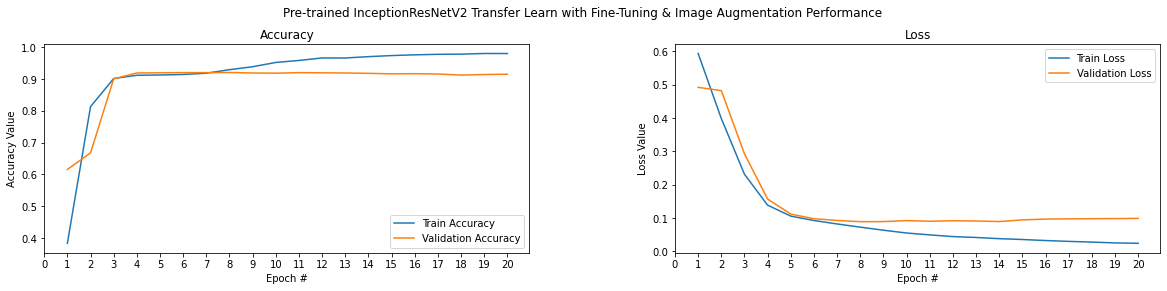

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionResNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [54]:
model.save('cm_train_model.h5')

In [72]:
test_dir = 'hackaton_dataset'
TEST = [f for f in os.listdir(data_dir+'/test') if f.endswith('.jpg')]

X_test = []
Y_test = []

for img in TEST:
    if "Ab01" in img:
        X_test.append(img_to_array(load_img(data_dir+'/test/'+img)).flatten() / 255.0)
        Y_test.append(1)
    elif "Ab04" in img:
        X_test.append(img_to_array(load_img(data_dir+'/test/'+img)).flatten() / 255.0)
        Y_test.append(2)
    elif "Ch02" in img:
        X_test.append(img_to_array(load_img(data_dir+'/test/'+img)).flatten() / 255.0)
        Y_test.append(3)
    elif "Ch05" in img:
        X_test.append(img_to_array(load_img(data_dir+'/test/'+img)).flatten() / 255.0)
        Y_test.append(4)
    elif "Mu02" in img:
        X_test.append(img_to_array(load_img(data_dir+'/test/'+img)).flatten() / 255.0)
        Y_test.append(5)
    elif "Mu04" in img:
        X_test.append(img_to_array(load_img(data_dir+'/test/'+img)).flatten() / 255.0)
        Y_test.append(6)
X_test = np.array(X_test)
X_test = X_test.reshape(-1, 128, 128, 3)

In [74]:
confidences = model.predict(X_test)
labels = np.round(confidences)

print(confidences)
print(labels)

[[7.9280608e-06 9.9860746e-01 2.4068422e-04 5.7859594e-05 1.9837095e-04
  8.4184721e-05 8.0363383e-04]]
[[0. 1. 0. 0. 0. 0. 0.]]
